In [1]:
import numpy as np
from keras import backend as K

def IoU(y_true, y_pred, eps=1e-6):
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3]) - intersection
    return -K.mean( (intersection + eps) / (union + eps), axis=0)

In [2]:
cd /content/drive/My Drive/HK201/BTL_TGM/Image_Segmentation

/content/drive/My Drive/HK201/BTL_TGM/Image_Segmentation


In [ ]:
import numpy as np

def main():
    total = np.load('train_image1.npy')
    for i in range(2,51):
        temp = np.load('train_image' + str(i) + '.npy')
        total = np.vstack((total, temp))

    np.save('final_train.npy', total)

    total = np.load('mask_image1.npy')
    for i in range(2,51):
        temp = np.load('mask_image' + str(i) + '.npy')
        total = np.vstack((total, temp))
    np.save('final_mask.npy', total)


if __name__ == '__main__':
    main()

In [3]:
from keras.models import Model, load_model
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model
import tensorflow as tf
import keras.backend as K
from keras.optimizers import Adam
from keras.losses import binary_crossentropy
import keras
from keras.callbacks import TensorBoard, ModelCheckpoint
from keras.layers import *


def get_model():
    K.clear_session()
    inputs = Input((256,256,3))
    s = BatchNormalization()(inputs) # we can learn the normalization step
    s = Dropout(0.5)(s)

    c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (s)
    c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (c1)
    p1 = MaxPool2D((2, 2)) (c1)

    c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (p1)
    c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (c2)
    p2 = MaxPool2D((2, 2)) (c2)

    c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (p2)
    c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (c3)
    p3 = MaxPool2D((2, 2)) (c3)

    c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (p3)
    c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (c4)
    p4 = MaxPool2D(pool_size=(2, 2)) (c4)

    c5 = Conv2D(128, (3, 3), activation='relu', padding='same') (p4)
    c5 = Conv2D(128, (3, 3), activation='relu', padding='same') (c5)

    add = MaxPool2D(pool_size=(2, 2)) (c5)

    add = Conv2D(256, (3, 3), activation='relu', padding='same') (add)
    add = Conv2D(256, (3, 3), activation='relu', padding='same') (add)
    
    add = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (add)
    add = concatenate([add, c5])
    add = Conv2D(128, (3, 3), activation='relu', padding='same') (add)
    add = Conv2D(128, (3, 3), activation='relu', padding='same') (add)

    u6 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (add)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (u6)
    c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (c6)

    u7 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (u7)
    c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (c7)

    u8 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (u8)
    c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (c8)

    u9 = Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (u9)
    c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (c9)

    outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

    model = Model(inputs=inputs, outputs=outputs)
    
    model.compile(optimizer=Adam(lr=1e-4), loss=IoU, metrics=['binary_accuracy'])
    model.summary()

    return model

In [4]:
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from keras.callbacks import TensorBoard, ModelCheckpoint

X = np.load('final_train.npy')
Y = np.load('final_mask.npy')

In [5]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, 
                                                    shuffle=True, 
                                                    random_state=265, 
                                                    test_size=0.1)
del X, Y
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, 
                                                  shuffle=True, 
                                                  random_state=265,
                                                  test_size=0.1)

In [6]:
print(X_train.shape)

(12150, 256, 256, 3)


In [7]:
def t_generator(X_train, Y_train, batch_size):
  features = np.zeros(shape=(batch_size, 256,256,3))
  labels = np.zeros(shape=(batch_size, 256,256,1))
  while True:
    start = 0
    end = batch_size
    for i in range(243):
      features = X_train[start:end]
      labels = Y_train[start:end]
      start = end
      end = end + batch_size
      yield features / 255.0, labels / 255.0
      
def v_generator(X_val, Y_val, batch_size):
  features = np.zeros(shape=(batch_size, 256,256,3))
  labels = np.zeros(shape=(batch_size, 256,256,1))
  while True:
    start = 0
    end = batch_size
    for i in range(27):
      features = X_val[start:end]
      labels = Y_val[start:end]
      start = end
      end = end + batch_size
      yield features / 255.0, labels / 255.0

In [8]:
# Free up RAM in case the model definition cells were run multiple times
keras.backend.clear_session()

model = get_model()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 3)  12          input_1[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 256, 256, 3)  0           batch_normalization[0][0]        
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 8)  224         dropout[0][0]                    
_______________________________________________________________________________________

In [10]:
tb = TensorBoard(log_dir='./logs/', write_graph=True)
model_chkpt = ModelCheckpoint('unet_model_self_02.h5',
                              monitor='val_loss', verbose=1, 
                              save_best_only=True)

In [12]:
history = model.fit_generator(generator = t_generator(X_train, Y_train, 50), 
                              steps_per_epoch=X_train.shape[0] // 50, 
                              epochs=100, callbacks=[model_chkpt], 
                              validation_data=v_generator(X_val, Y_val, 50),
                              validation_steps=X_val.shape[0] // 50)

243/243 [==============================] - ETA: 0s - loss: -0.9774 - binary_accuracy: 0.9941
Epoch 00094: val_loss did not improve from -0.96484
243/243 [==============================] - 65s 266ms/step - loss: -0.9774 - binary_accuracy: 0.9941 - val_loss: -0.9596 - val_binary_accuracy: 0.9906
Epoch 95/100
243/243 [==============================] - ETA: 0s - loss: -0.9756 - binary_accuracy: 0.9936
Epoch 00095: val_loss did not improve from -0.96484
243/243 [==============================] - 64s 265ms/step - loss: -0.9756 - binary_accuracy: 0.9936 - val_loss: -0.9545 - val_binary_accuracy: 0.9895
Epoch 96/100
243/243 [==============================] - ETA: 0s - loss: -0.9794 - binary_accuracy: 0.9943
Epoch 00096: val_loss did not improve from -0.96484
243/243 [==============================] - 64s 265ms/step - loss: -0.9794 - binary_accuracy: 0.9943 - val_loss: -0.9600 - val_binary_accuracy: 0.9902
Epoch 97/100
243/243 [==============================] - ETA: 0s - loss: -0.9810 - binary_

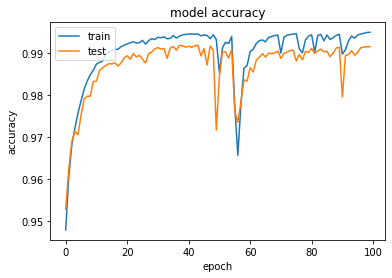

In [13]:
import matplotlib.pyplot as plt
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

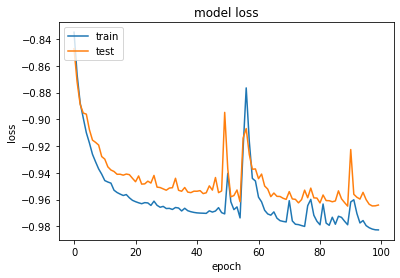

In [14]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
plt.imsave('test_05.jpg', X_test[28])

In [ ]:
!python test_model.py

2020-11-12 13:18:07.500331: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2020-11-12 13:18:09.374510: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2020-11-12 13:18:09.378401: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:982] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2020-11-12 13:18:09.378979: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla T4 computeCapability: 7.5
coreClock: 1.59GHz coreCount: 40 deviceMemorySize: 14.73GiB deviceMemoryBandwidth: 298.08GiB/s
2020-11-12 13:18:09.379024: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2020-11-12 13:18:09.380862: I tensorflow/stream_executor/platform/default